In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
import re
from math import sqrt
import os
import warnings

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout, RNN
from keras_tuner import BayesianOptimization, RandomSearch, GridSearch
import keras

2023-05-06 20:13:11.796785: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Multivariate Time Series Forecasting with LSTMs

## 2.1. DATA prep and EDA

In [2]:
country = 'canada'

df_MRD = pd.read_excel(io = f'../../../data/processed/{country}.xlsx')

In [4]:
df_MRD.dtypes

Time                                                                                                          datetime64[ns]
Unemployment_Rate_MEN                                                                                                float64
Unemployment_Rate_TOT                                                                                                float64
Unemployment_Rate_WOMEN                                                                                              float64
Electricity_Distribution_Losses                                                                                      float64
Electricity_Final_Consumption_(Calculated)                                                                           float64
Economic_Activity|Industrial_Production|Index|Base_Year-2010=100                                                     float64
Economic_Activity|Industrial_Production|Manufacturing|Index|Base_Year-2010=100                                       float64


In [5]:
df_MRD = df_MRD.drop(columns = [
    'Unemployment_Rate_MEN', 'Unemployment_Rate_WOMEN', 
    'Labor_Force|Persons|Number_of', 'Employment|Persons|Number_of', 'Unemployment|Persons|Number_of'
    ], inplace = False
)

In [11]:
df_MRD = df_MRD.set_index('Time')

### 2.1.5. Scaling and Trend Analysis

In [12]:
scaler=MinMaxScaler()

df_MRD_scaled=scaler.fit_transform(df_MRD)
df_MRD_scaled=pd.DataFrame(df_MRD_scaled,columns=df_MRD.columns)

df_MRD_scaled.index=df_MRD.index

In [13]:
for col in df_MRD_scaled.columns:
    max_time=df_MRD_scaled[~df_MRD_scaled[col].isna()].index[-1]
    print('%s : %s'%(col,max_time))

Unemployment_Rate_TOT : 2023-03-01 00:00:00
Electricity_Distribution_Losses : 2023-01-01 00:00:00
Electricity_Final_Consumption_(Calculated) : 2023-01-01 00:00:00
Economic_Activity|Industrial_Production|Index|Base_Year-2010=100 : 2022-02-01 00:00:00
Economic_Activity|Industrial_Production|Manufacturing|Index|Base_Year-2010=100 : 2022-01-01 00:00:00
Economic_Activity|Oil_Production|Crude|Index|Base_Year-2010=100 : 2022-01-01 00:00:00
Industrial_Production|Seasonally_adjusted|Index|Base_Year-2010=100 : 2022-02-01 00:00:00
Financial_Market_Prices|Equities|End_of_Period|Index|Base_Year-None : 2017-04-01 00:00:00
Financial_Market_Prices|Equities|Index|Base_Year-None : 2017-04-01 00:00:00
Prices|Consumer_Price_Index|All_items|Index|Base_Year-2010=100 : 2023-03-01 00:00:00
Prices|Producer_Price_Index|All_Commodities|Index|Base_Year-2010=100 : 2019-02-01 00:00:00
Labor_Markets|Unemployment_Rate|Percent : 2022-03-01 00:00:00
Change_in_Inventories|Nominal|Undjusted|Domestic_Currency : 2022-12-01

In [22]:
# col_not_available=[
#     'Financial Market Prices, Equities, Index','Central Bank Policy Rate','Deposit Rate',
#     'Discount Rate','Lending Rate', 'Money Market Rate','Treasury Bill Rate'
# ]
                   
# col_not_available_high_correlation=['Labor Markets, Wage Rates, Index','Government Bonds']

# seasonally_adjusted_col=[col for col in df_MRD_scaled.columns if re.search(r'Seasonally Adjusted',col,re.I)]
                   
# df_MRD.drop(columns=col_not_available + col_not_available_high_correlation,inplace=True)

## 2.2. Modelling

### 2.2.1. Reframe time series to supervised learning

In [14]:
df_MRD

,Unemployment_Rate_TOT,Electricity_Distribution_Losses,Electricity_Final_Consumption_(Calculated),Economic_Activity|Industrial_Production|Index|Base_Year-2010=100,Economic_Activity|Industrial_Production|Manufacturing|Index|Base_Year-2010=100,Economic_Activity|Oil_Production|Crude|Index|Base_Year-2010=100,Industrial_Production|Seasonally_adjusted|Index|Base_Year-2010=100,Financial_Market_Prices|Equities|End_of_Period|Index|Base_Year-None,Financial_Market_Prices|Equities|Index|Base_Year-None,Prices|Consumer_Price_Index|All_items|Index|Base_Year-2010=100,...,Statistical_Discrepancy_in_GDP|Real|Seasonally_Adjusted|Domestic_Currency|Base_Year-2012.0,Consumer_Confidence,Business_Confidence,Central_Bank_Policy_Rate,Deposit_Rate,Government_Bonds,Lending_Rate,Money_Market_Rate,Savings_Rate,Treasury_Bill_Rate
Time,,,,,,,,,,,,,,,,,,,,,
1955-01-01,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-02-01,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-03-01,4.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-04-01,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1955-05-01,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,5.1,2892.6603,47497.8413,NaN,NaN,NaN,NaN,NaN,NaN,132.226674,...,270.266667,96.640571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01,5.0,3293.5636,53997.4223,NaN,NaN,NaN,NaN,NaN,NaN,131.453921,...,254.000000,96.707715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,5.0,3206.3869,54407.0291,NaN,NaN,NaN,NaN,NaN,NaN,132.140813,...,NaN,96.967366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
reframed_dataset = series_to_supervised(df_MRD, 5, 1)

### 2.2.2. Feature Selection

#### 2.2.2.1.Feature selection based on availability

In [17]:
# tlag_col=[col for col in reframed_dataset.columns if re.search(r't\)',col,re.I)==None]
# reframed_dataset_final=reframed_dataset[tlag_col+['var5(t)']]

tlag_col=[col for col in reframed_dataset.columns if re.search(r't-5',col,re.I)!=None]
reframed_dataset_final=reframed_dataset[tlag_col+['var5(t-1)','var5(t-2)','var5(t-3)','var5(t-4)']+['var5(t)']]

reframed_dataset_final.dropna(inplace=True)
reframed_dataset_final

/tmp/ipykernel_448672/564800525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed_dataset_final.dropna(inplace=True)


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var42(t-5),var43(t-5),var44(t-5),var45(t-5),var46(t-5),var5(t-1),var5(t-2),var5(t-3),var5(t-4),var5(t)
Time,,,,,,,,,,,,,,,,,,,,,
2010-06-01,8.4,4974.620,51287.873,96.4,89.7,97.8,95.907992,82.527177,96.535235,98.826560,...,3.92,2.25,0.24,0.05,0.18,102.7,99.9,101.3,97.1,107.1
2010-07-01,8.4,4395.764,45503.048,101.2,97.1,99.8,97.608134,86.509259,94.873534,99.255867,...,3.98,2.25,0.25,0.05,0.17,107.1,102.7,99.9,101.3,95.6
2010-08-01,8.3,4358.730,45156.806,100.6,101.3,98.8,98.708226,89.544990,99.123417,99.255867,...,3.99,2.25,0.24,0.05,0.29,95.6,107.1,102.7,99.9,101.9
2010-09-01,8.2,3783.301,39355.944,96.4,99.9,96.9,98.308192,90.831661,100.700298,99.599313,...,3.99,2.25,0.25,0.05,0.40,101.9,95.6,107.1,102.7,104.6
2010-10-01,8.1,3689.936,39205.139,97.6,102.7,96.9,100.408367,87.501283,97.841751,99.856898,...,3.58,2.25,0.24,0.05,0.43,104.6,101.9,95.6,107.1,104.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-01,6.9,3177.965,54137.824,112.6,99.1,129.7,114.109509,113.719704,126.356650,110.246136,...,2.24,2.70,0.49,0.05,0.47,110.7,111.6,107.6,102.1,113.3
2017-06-01,6.8,3478.668,54183.599,116.6,102.1,134.1,114.809567,114.451448,128.279025,111.190612,...,2.34,2.70,0.49,0.05,0.46,113.3,110.7,111.6,107.6,116.1
2017-07-01,6.6,3075.693,48271.712,119.6,107.6,135.2,114.209517,114.550234,129.547521,111.362335,...,2.29,2.70,0.49,0.05,0.48,116.1,113.3,110.7,111.6,106.5


#### 2.2.2.1.Feature selection using causality test

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1]

def check_stationarity(dataset):
    stationary_fields=[]
    non_stationary_fields=[]
    for col in dataset.columns:
        print('______%s_______'%col)
        p_value=adf_test(dataset[col])
        if p_value<=0.05:
            stationary_fields.append(col)
        else:
            non_stationary_fields.append(col)

    print('Number of stationary fields :%s'%len(stationary_fields))
    print('Number of non stationary fields :%s'%len(non_stationary_fields))
    
    return stationary_fields,non_stationary_fields

In [19]:
stationary_fields,non_stationary_fields=check_stationarity(reframed_dataset_final)

______var1(t-5)_______
ADF Statistics: -1.568980
p-value: 0.499155
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var2(t-5)_______
ADF Statistics: -1.424849
p-value: 0.570307
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var3(t-5)_______
ADF Statistics: -1.026134
p-value: 0.743614
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var4(t-5)_______
ADF Statistics: -0.765779
p-value: 0.828968
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var5(t-5)_______
ADF Statistics: -1.666519
p-value: 0.448440
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var6(t-5)_______
ADF Statistics: 0.056243
p-value: 0.962943
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var7(t-5)_______
ADF Statistics: -2.009530
p-value: 0.282410
Critical values:
	1%: -3.508
	5%: -2.895
	10%: -2.585
______var8(t-5)_______
ADF Statistics: -1.438172
p-value: 0.563845
Critical values:
	1%: -3.508
	5%: -2.895
	10%: -2.585
______var9(t-5)_______
ADF Statis

In [20]:
reframed_dataset_final_transformed = reframed_dataset_final.diff().dropna()
stationary_fields,non_stationary_fields=check_stationarity(reframed_dataset_final_transformed)

______var1(t-5)_______
ADF Statistics: -11.317003
p-value: 0.000000
Critical values:
	1%: -3.509
	5%: -2.896
	10%: -2.585
______var2(t-5)_______
ADF Statistics: -2.237501
p-value: 0.192917
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var3(t-5)_______
ADF Statistics: -4.607125
p-value: 0.000125
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var4(t-5)_______
ADF Statistics: -2.340550
p-value: 0.159223
Critical values:
	1%: -3.521
	5%: -2.901
	10%: -2.588
______var5(t-5)_______
ADF Statistics: -2.259817
p-value: 0.185255
Critical values:
	1%: -3.522
	5%: -2.901
	10%: -2.588
______var6(t-5)_______
ADF Statistics: -2.418259
p-value: 0.136649
Critical values:
	1%: -3.522
	5%: -2.901
	10%: -2.588
______var7(t-5)_______
ADF Statistics: -7.782850
p-value: 0.000000
Critical values:
	1%: -3.510
	5%: -2.896
	10%: -2.585
______var8(t-5)_______
ADF Statistics: -8.147148
p-value: 0.000000
Critical values:
	1%: -3.509
	5%: -2.896
	10%: -2.585
______var9(t-5)_______
ADF Stat

In [21]:
reframed_dataset_final_transformed.drop(columns=non_stationary_fields,inplace=True)

In [23]:
correlated_col=[]
for col in [col for col in reframed_dataset_final_transformed.columns if col!='var5(t)']:
    print('_____________Granger Causality test between Unemployment Rate and %s___________________'%(col))
    granger_ = grangercausalitytests(reframed_dataset_final_transformed[['var1(t-5)', col]], 4)
    if (granger_[1][0]['ssr_chi2test'][1]<=0.05)|(granger_[2][0]['ssr_chi2test'][1]<=0.05)|(granger_[3][0]['ssr_chi2test'][1]<=0.05)|(granger_[4][0]['ssr_chi2test'][1]<=0.05):
        correlated_col.append(col)

_____________Granger Causality test between Unemployment Rate and var1(t-5)___________________

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=84, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=1
parameter F test:         F=4.1453  , p=0.0449  , df_denom=84, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=82, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=2.7432  , p=0.0703  , df_denom=82, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=80, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=1.8767  , p=0.1402  , df_denom=80, df_num=3

Gran

In [24]:
reframed_dataset_final_features=reframed_dataset_final[correlated_col+['var1(t-5)']].copy()

In [25]:
reframed_dataset_final_features

,var8(t-5),var28(t-5),var32(t-5),var37(t-5),var1(t-5)
Time,,,,,
2010-06-01,82.527177,-136.000000,99.178574,-143.100000,8.4
2010-07-01,86.509259,-174.000000,99.439291,-182.700000,8.4
2010-08-01,89.544990,-212.000000,99.700008,-222.300000,8.3
2010-09-01,90.831661,-230.000000,99.712182,-241.133333,8.2
2010-10-01,87.501283,-248.000000,99.724357,-259.966667,8.1
...,...,...,...,...,...
2017-05-01,113.719704,328.000000,109.516111,313.000000,6.9
2017-06-01,114.451448,59.333333,109.853772,58.000000,6.8
2017-07-01,114.550234,-209.333333,110.191434,-197.000000,6.6


### 2.2.3. Split to train-test and reframe

In [26]:
scaler=MinMaxScaler()
reframed_dataset_final_scaled=scaler.fit_transform(reframed_dataset_final_features)
reframed_dataset_final_scaled=pd.DataFrame(reframed_dataset_final_scaled,columns=reframed_dataset_final_features.columns)

reframed_dataset_final_scaled.index=reframed_dataset_final_features.index

In [27]:
reframed_dataset_final_scaled

,var8(t-5),var28(t-5),var32(t-5),var37(t-5),var1(t-5)
Time,,,,,
2010-06-01,0.000000,0.424760,0.000000,0.435994,1.000000
2010-07-01,0.118135,0.384205,0.022951,0.394511,1.000000
2010-08-01,0.208195,0.343650,0.045902,0.353027,0.947368
2010-09-01,0.246366,0.324440,0.046973,0.333298,0.894737
2010-10-01,0.147565,0.305229,0.048045,0.313569,0.842105
...,...,...,...,...,...
2017-05-01,0.925379,0.919957,0.910013,0.913786,0.210526
2017-06-01,0.947087,0.633227,0.939737,0.646658,0.157895
2017-07-01,0.950018,0.346496,0.969461,0.379531,0.052632


In [28]:
reframed_dataset_final_scaled_values=reframed_dataset_final_scaled.values

train_limit=reframed_dataset_final_scaled_values.shape[0]-12

train_X=reframed_dataset_final_scaled_values[0:train_limit,:-1]
train_Y=reframed_dataset_final_scaled_values[0:train_limit,-1]

test_X=reframed_dataset_final_scaled_values[train_limit:,:-1]
test_Y=reframed_dataset_final_scaled_values[train_limit:,-1]

In [29]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(76, 1, 4) (76,) (12, 1, 4) (12,)


### 2.2.4. Hyperparameter Tuning using GridSearch

2023-05-06 20:31:39.802246: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100


2023-05-06 20:31:40.327063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 20:31:40.328718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 20:31:40.330409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 - 4s - loss: 0.4178 - val_loss: 0.0847 - 4s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.4028 - val_loss: 0.0685 - 110ms/epoch - 55ms/step
Epoch 3/100
2/2 - 0s - loss: 0.3879 - val_loss: 0.0539 - 169ms/epoch - 84ms/step
Epoch 4/100
2/2 - 0s - loss: 0.3731 - val_loss: 0.0462 - 143ms/epoch - 72ms/step
Epoch 5/100
2/2 - 0s - loss: 0.3585 - val_loss: 0.0437 - 123ms/epoch - 62ms/step
Epoch 6/100
2/2 - 0s - loss: 0.3444 - val_loss: 0.0587 - 138ms/epoch - 69ms/step
Epoch 7/100
2/2 - 0s - loss: 0.3319 - val_loss: 0.0739 - 131ms/epoch - 65ms/step
Epoch 8/100
2/2 - 0s - loss: 0.3197 - val_loss: 0.0953 - 129ms/epoch - 65ms/step
Epoch 9/100
2/2 - 0s - loss: 0.3079 - val_loss: 0.1191 - 131ms/epoch - 65ms/step
Epoch 10/100
2/2 - 0s - loss: 0.2973 - val_loss: 0.1429 - 113ms/epoch - 57ms/step
Epoch 11/100
2/2 - 0s - loss: 0.2881 - val_loss: 0.1669 - 151ms/epoch - 76ms/step
Epoch 12/100
2/2 - 0s - loss: 0.2791 - val_loss: 0.1911 - 127ms/epoch - 63ms/step
Epoch 13/100
2/2 - 0s - loss: 0.2709 - val

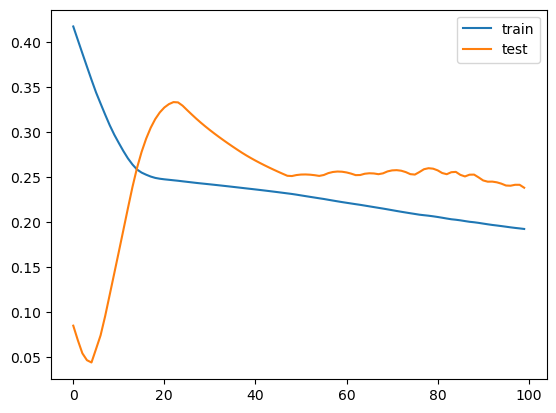

In [30]:
# Fitting model without any hyperparameter tuning
model_no_tuned = Sequential()
model_no_tuned.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_no_tuned.add(Dense(1))
model_no_tuned.compile(loss='mae', optimizer='adam')
# fit network
history = model_no_tuned.fit(train_X, train_Y, epochs=100, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [31]:
# make a prediction
yhat = model_no_tuned.predict(test_X)

# invert scaling for forecast
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((test_X_reshaped, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_Y_reshaped = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_X_reshaped,test_Y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

1/1 [==============================] - 1s 630ms/step


2023-05-06 20:32:15.090576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 20:32:15.093223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 20:32:15.095714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [32]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %s' % rmse)

Test RMSE: 0.47604822094790694


In [33]:
# Fitting best model using hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(hp.Int('input_unit',min_value=10,max_value=500,step=1),return_sequences=True, 
                   input_shape=(train_X.shape[1],train_X.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=10,max_value=500,step=1),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=10,max_value=500,step=1)))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.99,step=0.1)))
    
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['sigmoid','relu','tanh','linear','selu','elu'],
                                            default='relu')))
    
    model.compile(loss='mean_squared_error', 
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),metrics =['mse'])
    return model

tuner= GridSearch(
        build_model,
        objective='mse',
        max_trials=10,
        executions_per_trial=1,
        overwrite=True,
        project_name=f'keras_tuning_{country}_LSTM'
        )

tuner.search(
        x=train_X,
        y=train_Y,
        epochs=100,
        batch_size=72,
        validation_data=(test_X,test_Y),
)

Trial 10 Complete [00h 00m 28s]
mse: 0.0054850829765200615

Best mse So Far: 0.0054850829765200615
Total elapsed time: 00h 06m 23s
INFO:tensorflow:Oracle triggered exit


In [34]:
best_model = tuner.get_best_models(num_models=1)[0]

2023-05-06 20:39:29.950150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 20:39:29.952715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 20:39:29.954268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [35]:
# make a prediction
yhat = best_model.predict(test_X)

# invert scaling for forecast
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((test_X_reshaped, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_Y_reshaped = test_Y.reshape((len(test_Y), 1))
inv_y = concatenate((test_X_reshaped,test_Y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

2023-05-06 20:39:39.208855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 20:39:39.211630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 20:39:39.213664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


In [36]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %s' % rmse)

Test RMSE: 0.20040870318209938
